# Waveguide Tomography: Cross-Section Reconstruction

This tutorial demonstrates tomographic reconstruction of the refractive index
profile of a photoinscribed waveguide in glass. By measuring the transmitted
intensity at multiple illumination angles, we reconstruct the 2D cross-section
of the waveguide using angular spectrum beam propagation and inverse optimization.

> **Reference**
>
> This tutorial follows the approach described in: N. Barré, R. Shivaraman,
> L. Ackermann, S. Moser, M. Schmidt, P. Salter, M. Booth, and A. Jesacher,
> ["Tomographic refractive index profiling of direct laser written waveguides"](https://doi.org/10.1364/OE.434846),
> Opt. Express **29**, 35414-35425 (2021).

Unlike traditional tomography based on the Born or Rytov approximations, this
approach uses full wave propagation through the sample with accelerated proximal
gradient descent. This handles strong refractive index contrasts and gradients
without approximation. A key feature is joint estimation of optical aberrations
alongside the refractive index profile, which is critical for using high-angle
data and achieving accurate reconstructions.

## Physical Setup

The waveguide is invariant along the propagation direction (y), allowing us to
treat it as a 2D problem. We illuminate the sample at different angles θ and
measure the transmitted intensity pattern. The angular diversity provides the
tomographic information needed to reconstruct the refractive index profile Δn(x,z).

In [1]:
using FluxOptics, Zygote, CairoMakie
using CUDA  # Comment if you don't have CUDA
using JLD

## Experimental Data

We load the measured intensity map I(x,θ) showing the transmitted field intensity
as a function of transverse position x and illumination angle θ. The data comes
from a photoinscribed waveguide in borosilicate glass.

In [2]:
data = "data"

tomogram_data = load("$(data)/tomogram_guide_b.jld")

dx = tomogram_data["dx"]              # Pixel size (μm)
I_measured = tomogram_data["I"]       # Intensity map I(x,θ)
θ_angles = tomogram_data["θ_l"];      # Illumination angles (rad)

Visualize the full measured tomogram showing intensity variation with angle

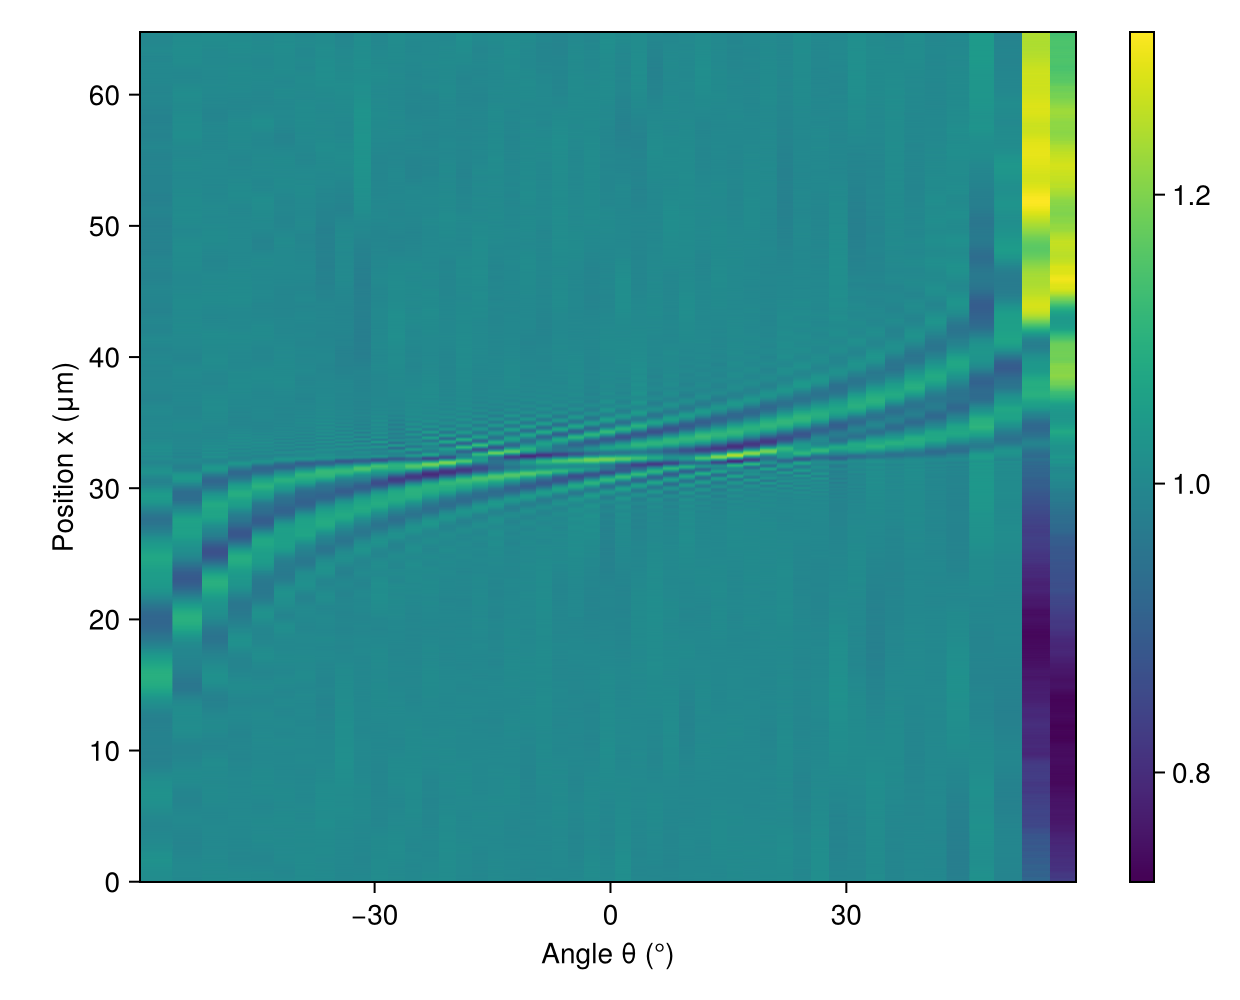

In [3]:
fig_full = Figure(size = (620, 500))
ax = Axis(fig_full[1, 1], xlabel = "Angle θ (°)", ylabel = "Position x (μm)", aspect = 1.1)
hm = heatmap!(ax, rad2deg.(θ_angles), (0:size(I_measured, 1)-1) .* dx, I_measured')
Colorbar(fig_full[1, 2], hm)
fig_full

## Angular Selection

We select a subset of angles around normal incidence (θ ≈ 0) for reconstruction.
Each angle provides a different view of the waveguide structure. The intensities
are normalized to unit power at each angle.

In [4]:
angle_indices = (25 - 20):1:(25 + 22)
θ_selected = θ_angles[angle_indices]
I_selected = I_measured[:, angle_indices]
I_selected .*= size(I_selected, 1) ./ sum(I_selected, dims = 1)

nx = size(I_selected, 1)
n_angles = length(θ_selected);

Visualize the selected angular range used for reconstruction

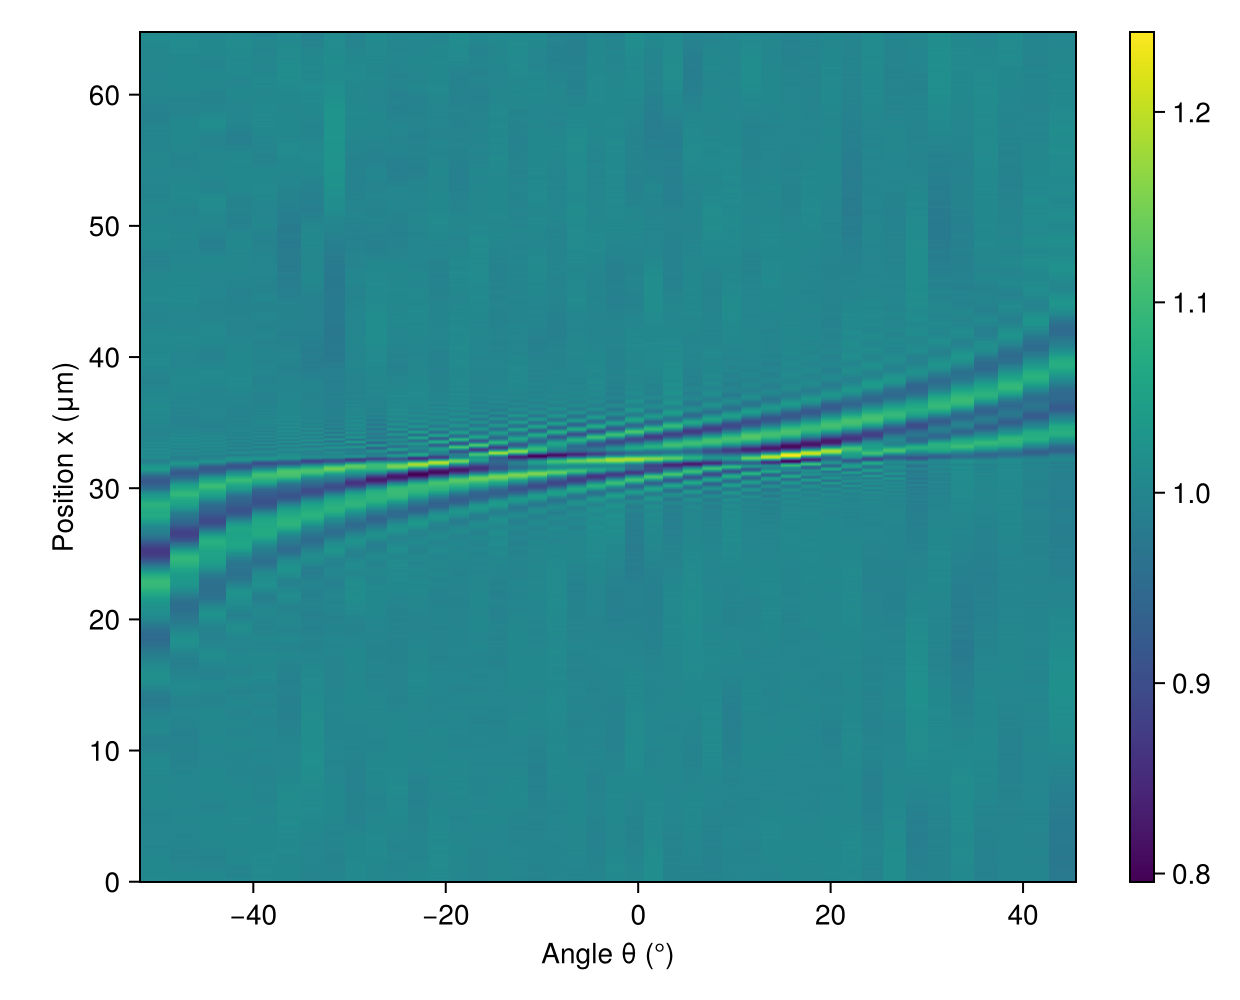

In [5]:
fig_selected = Figure(size = (620, 500))
ax = Axis(fig_selected[1, 1], xlabel = "Angle θ (°)", ylabel = "Position x (μm)", aspect = 1.1)
hm = heatmap!(ax, rad2deg.(θ_selected), (0:nx-1) .* dx, I_selected')
Colorbar(fig_selected[1, 2], hm)
fig_selected

## Forward Model: Beam Propagation Through Sample

We construct the optical system modeling wave propagation through the waveguide.
The system consists of:
1. Multi-angle plane wave illumination with tilts θ
2. AS-BPM propagation through the sample (trainable refractive index)
3. Free-space propagation with NA-limited collection aperture
4. Aberration correction using a Fourier-space phase basis

In [6]:
n_bulk = 1.52        # Bulk refractive index of glass
λ = 0.455            # Blue illumination wavelength (μm)
NA = 1.4             # Numerical aperture of collection optics
nz = 300             # Number of propagation steps
L_sample = 20        # Sample thickness (μm)
Δn_initial = zeros(nx, nz);  # Initial refractive index perturbation

Create multi-angle source field

In [7]:
u0 = ScalarField((nx, n_angles), (dx,), λ; tilts = (θ_selected,))
fill!(u0, 1)
u0 = cu(u0)  # Comment if you don't have CUDA
s = ScalarSource(u0);

Beam propagation through sample (trainable)

In [8]:
sample = AS_BPM(u0, L_sample, n_bulk, Δn_initial;
                use_cache = false, trainable = true, buffered = true);

NA-limited collection aperture

In [9]:
make_diaphragm(NA, λ) = fx -> abs(fx) <= abs(NA/λ) ? true : false

Δz_propagation = -6  # Free-space propagation distance (μm)
p_collection = ASProp(u0, Δz_propagation; n0 = n_bulk,
                      filter = make_diaphragm(NA, λ),
                      use_cache = false);  # Small data: cache slower than recompute

## Aberration Correction

Optical aberrations in the collection path (e.g., from refractive index mismatch
between sample and immersion medium) are modeled using a radial polynomial basis
in Fourier space. We jointly estimate these aberrations alongside the refractive
index profile - a form of blind deconvolution.

This joint estimation is crucial: the paper shows that neglecting aberrations
produces significant artifacts in the reconstructed index profile, especially
when using high-angle illumination data. The radial polynomial basis (even orders
up to 16th) captures spherical-like aberrations common in high-NA imaging systems.

In [10]:
spatial_freq_offsets = sin.(θ_selected) .* (n_bulk/λ)

function radial_polynomial(fx, f0, λ, NA, p)
    abs(fx + f0) <= abs(NA/λ) ? (abs(fx + f0) * λ / NA)^(2*p) : 0.0
end

aberration_mask = FourierPhase(u0, zeros(nx, n_angles);
                               trainable = true, buffered = true);

n_basis = 8
basis_functions = make_fourier_basis((fx, f0, p) -> radial_polynomial(fx, f0, λ, NA, p),
                                     (nx,), (dx,), spatial_freq_offsets, (1:n_basis)')
aberration_wrapper = BasisProjectionWrapper(aberration_mask, basis_functions,
                                            zeros(n_basis));

Complete optical system

In [11]:
system = s |> sample |> p_collection |> aberration_wrapper |>
         (; inplace = true, merge_components = true);

## Loss Function and Optimization Setup

We minimize the squared difference between measured and simulated intensities.
The waveguide refractive index and aberration coefficients are jointly optimized.

For regularization, we use ISTA (Iterative Shrinkage-Thresholding Algorithm) which
promotes sparsity in the reconstruction. This is simpler than the TV-norm
regularization used in the original paper, and produces smoother profiles without
the "staircase" artifacts characteristic of total variation methods.

In [12]:
I_target = similar(u0.electric, real(eltype(u0)))
copyto!(I_target, I_selected)

intensity_metric = SquaredIntensityDifference((u0, I_target));

f_opt = m -> sum(intensity_metric(m().out));

Initialize trainable components

In [13]:
fill!(sample, 0)
fill!(aberration_wrapper, 0)
fill!(aberration_mask, 0);

Separate optimization rules for sample and aberrations

In [14]:
sample_rule = ProxRule(Fista(0.01), IstaProx(3e-5))  # ISTA regularization
aberration_rule = Fista(0.03)

rules_dict = make_rules(sample => sample_rule,
                        aberration_wrapper => aberration_rule)

opt = FluxOptics.setup(rules_dict, system)

_, g = Zygote.withgradient(f_opt, system);  # Warm-up
FluxOptics.update!(opt, system, g[1]);  # Warm-up

## Reconstruction Loop

We run 50 iterations of FISTA with proximal regularization. The algorithm
alternates between updating the refractive index profile and correcting
for optical aberrations, progressively refining the tomographic reconstruction.

In [15]:
losses = Float64[]

@time for i in 1:50
    val, grads = Zygote.withgradient(f_opt, system)
    FluxOptics.update!(opt, system, grads[1])
    push!(losses, val)
end

  2.480581 seconds (13.47 M allocations: 375.960 MiB, 5.32% gc time)


Convergence curve showing reconstruction progress

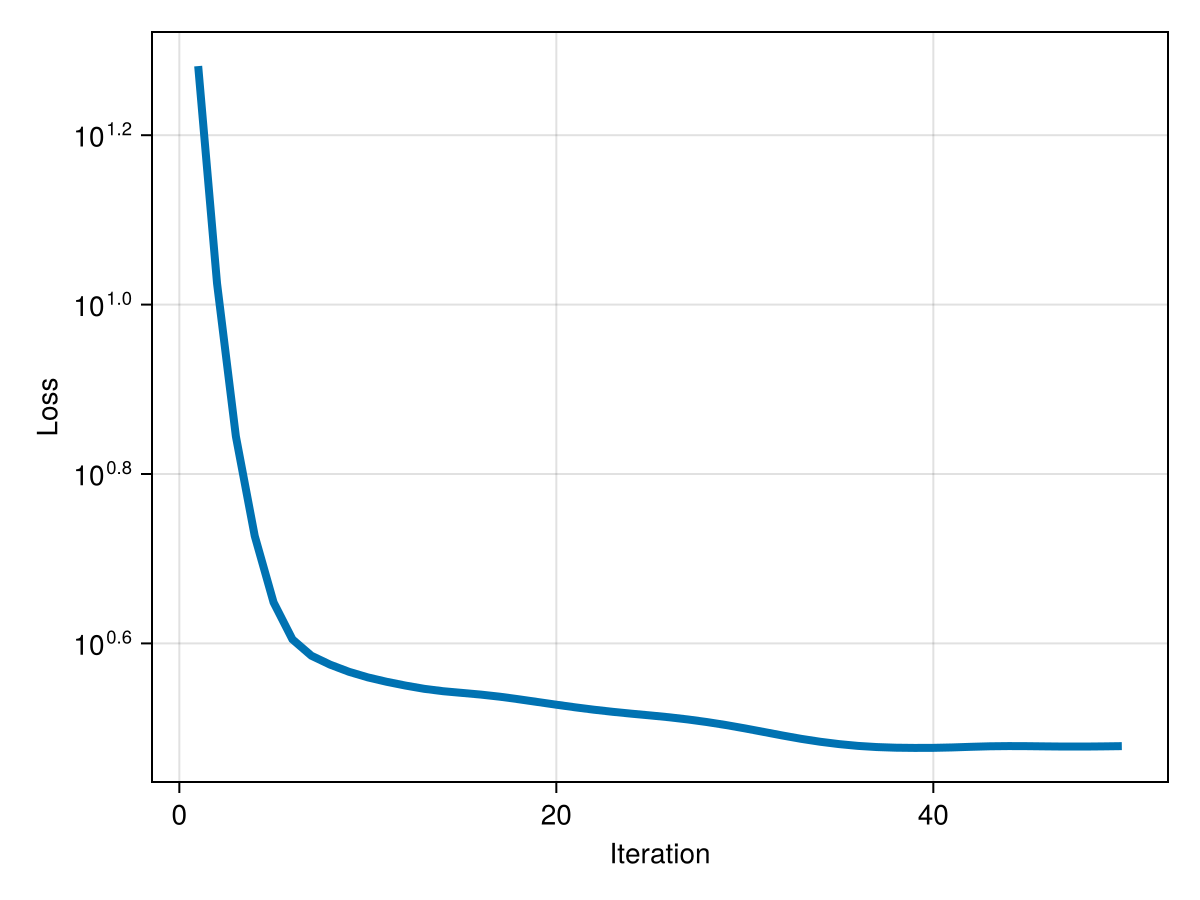

In [16]:
fig_loss = Figure()
ax = Makie.Axis(fig_loss[1, 1], yscale = log10, xlabel = "Iteration", ylabel = "Loss")
lines!(ax, losses; linewidth = 4)
fig_loss

## Reconstructed Intensity Pattern

The optimized forward model closely matches the measured intensities across
all angles, validating the reconstruction accuracy.

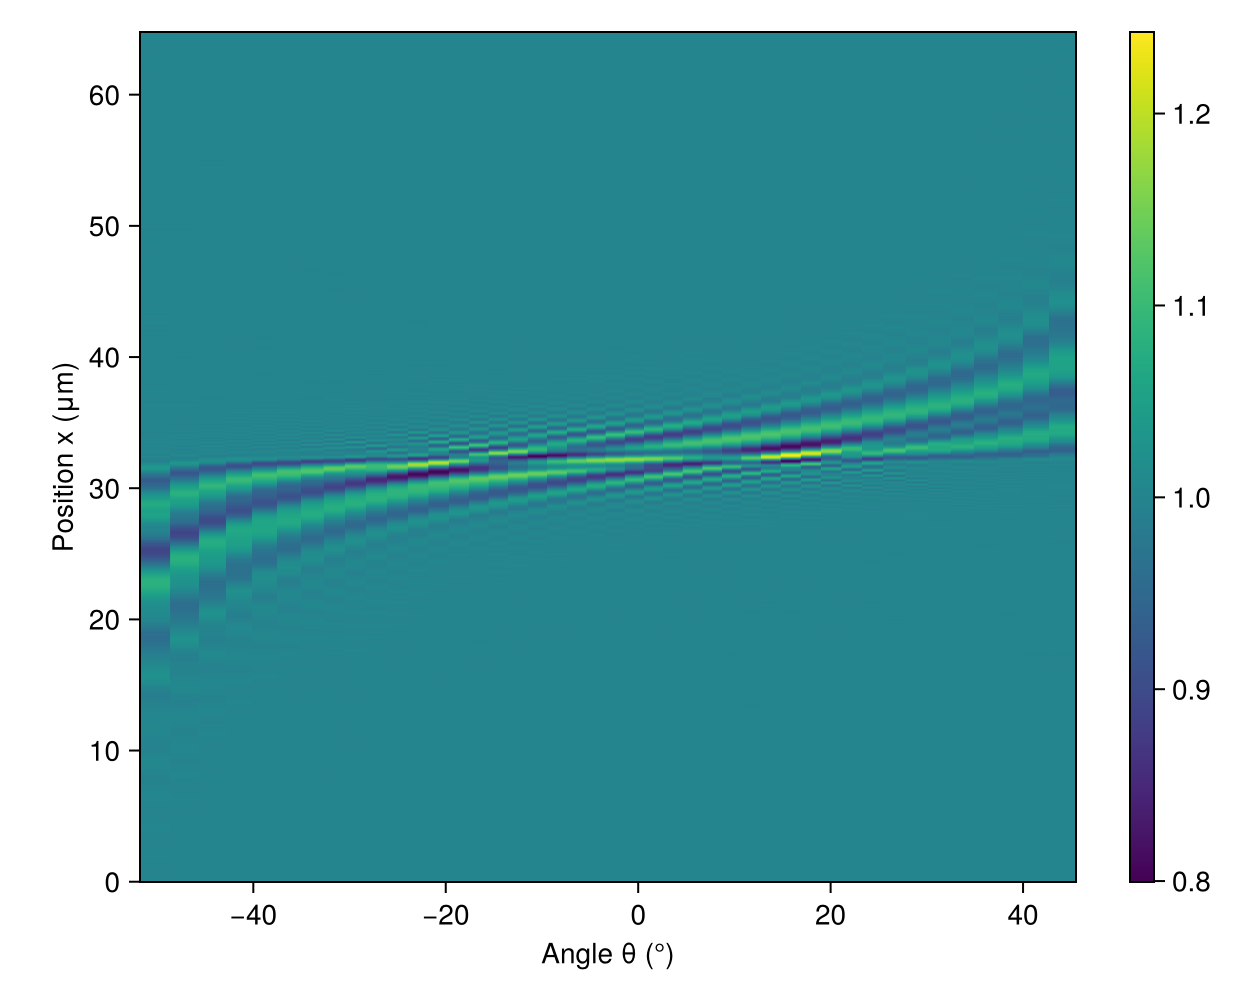

In [17]:
I_reconstructed = abs2.(collect(system().out))

fig_recon_intensity = Figure(size = (620, 500))
ax = Axis(fig_recon_intensity[1, 1], xlabel = "Angle θ (°)", ylabel = "Position x (μm)", aspect = 1.1)
I_reconstructed = abs2.(collect(system().out))
hm = heatmap!(ax, rad2deg.(θ_selected), (0:nx-1) .* dx, I_reconstructed')
Colorbar(fig_recon_intensity[1, 2], hm)
fig_recon_intensity

## Refractive Index Profile

The reconstructed 2D refractive index perturbation Δn(x,z) reveals the waveguide
cross-section. The computational domain was chosen large enough to accommodate
high-angle illumination without edge effects. We now crop to the central region
containing the waveguide for visualization. The photoinscribed region shows
increased refractive index, characteristic of direct laser writing in glass.

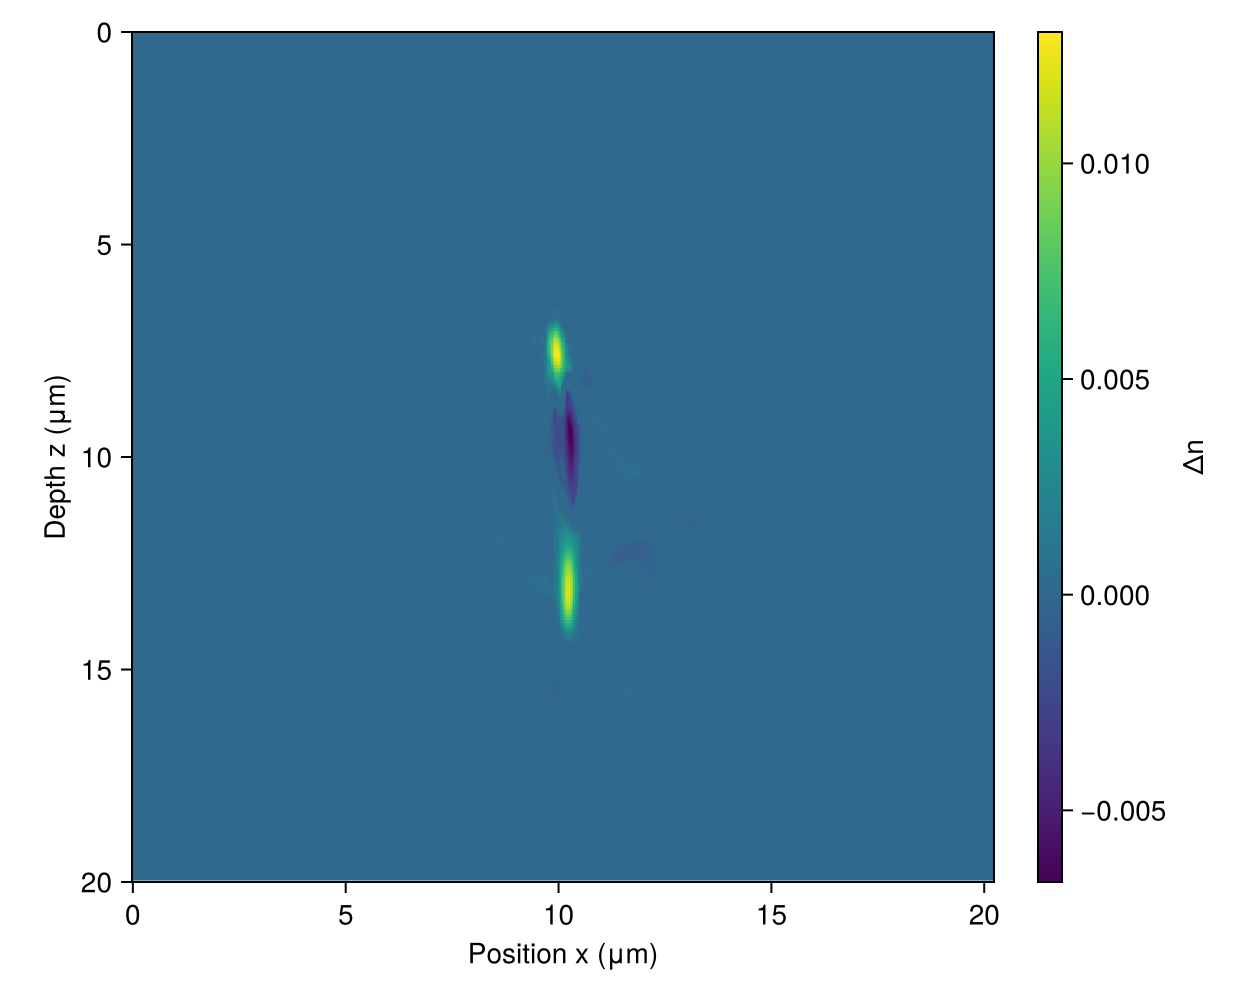

In [18]:
n_trim = 550  # Crop to central region containing the waveguide
Δn_reconstructed = collect(sample)[(1 + n_trim):(end - n_trim), end:-1:1]

fig_profile = Figure(size = (620, 500))
ax = Axis(fig_profile[1, 1], xlabel = "Position x (μm)", ylabel = "Depth z (μm)")
hm = heatmap!(ax, (0:(nx - 2*n_trim - 1)) .* dx, (0:(nz-1)) .* (L_sample/nz), Δn_reconstructed)
ax.aspect = DataAspect()
ylims!(ax, L_sample, 0)
Colorbar(fig_profile[1, 2], hm, label = "Δn")
fig_profile

## Recovered Aberration Profile

The optimization also recovers the optical aberration profile as a function
of numerical aperture. The radial polynomial basis captures symmetric aberrations
in the collection optics. The phase correction is valid within the collection
NA window (shown by red dashed lines).

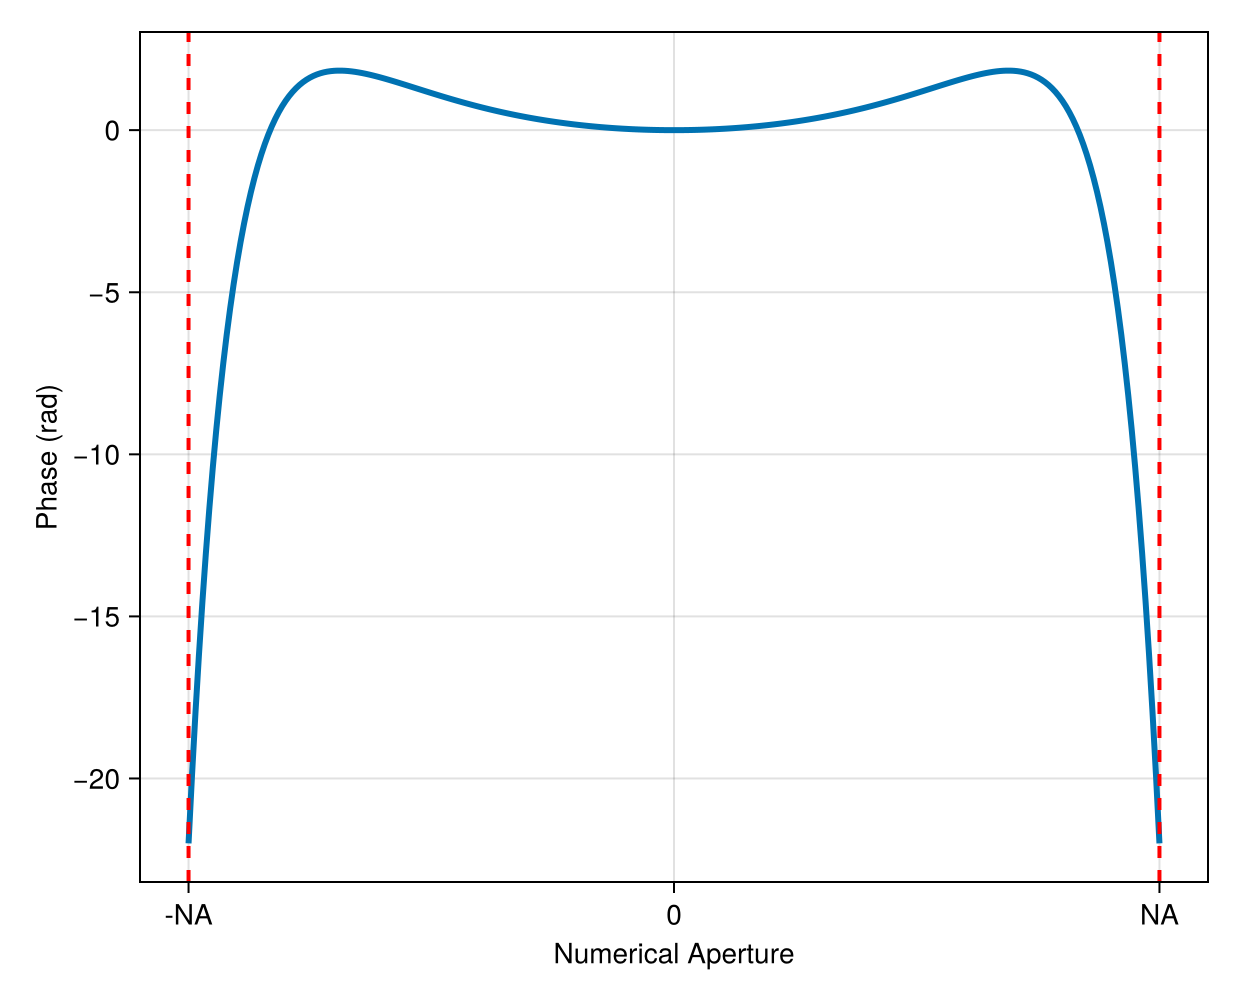

In [19]:
NA_range = (-NA):0.01:NA
fx_range = NA_range ./ λ
coefficients = collect(aberration_wrapper)
aberration_phase = sum([coefficients[i] * radial_polynomial.(fx_range, 0, λ, NA, p)
                        for (i, p) in enumerate(1:n_basis)])

fig_aberration = Figure(size = (620, 500))
ax = Axis(fig_aberration[1, 1], xlabel = "Numerical Aperture", ylabel = "Phase (rad)",
          xticks = ([-NA, 0, NA], ["-NA", "0", "NA"]))
lines!(ax, NA_range, aberration_phase; linewidth = 3)
vlines!(ax, [NA, -NA]; linestyle = :dash, color = :red, linewidth = 2)
fig_aberration

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*